<a href="https://colab.research.google.com/github/AyushGupta51379/COMP_5331_Project_Fake_News_Detection/blob/master/broken%20gru_of_pixel_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Upload datasets to google drive and mount it on Colab

In [1]:
import torch                       # pytorch
import torch.nn as nn              # pytorch for neural network
from torchvision import datasets, transforms # for loading and transform images to tensor
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt    # to plot graph

In [2]:
  
from google.colab import drive
from IPython.display import clear_output

drive.mount('/content/drive')
# ls 'drive/My Drive/

!unzip 'drive/My Drive/MM17-WeiboRumorSet.zip'

clear_output()
print("unzipping details have been cleared.")

unzipping details have been cleared.


# Read all images, resize images into (image_height,image_width), convert into tensor type

Reference/Tutorial
- A Beginner’s Tutorial on Building an AI Image Classifier using PyTorch **(from data loading, processing to training and evaluation)**
   - https://towardsdatascience.com/a-beginners-tutorial-on-building-an-ai-image-classifier-using-pytorch-6f85cb69cba7

In [3]:
# mainfolder = 'drive/My Drive/COMP5331 Fall 2020/MM17-WeiboRumorSet/'
mainfolder = 'MM17-WeiboRumorSet/'
image_height = 224
image_width  = 224
mytransform = transforms.Compose([transforms.Resize((image_height,image_width), interpolation=Image.NEAREST),   # to resize our source images
                                  transforms.ToTensor()])                                      # then convert into tensors 

dataset = datasets.ImageFolder(mainfolder, transform= mytransform) 
# NOTE: The path should point to a place with subfolders (which contain images inside).
#  It will report bugs if there is no subfolder.
# print(type(dataset))
print('Total no. of images: ', len(dataset))

print(round(len(dataset)*0.5))

# 50% train, 50% test
trainset, testset = torch.utils.data.random_split(dataset, [round(len(dataset)*0.8), round(len(dataset)*0.2)])
print('Total no. of train set images: ', len(trainset))
print('Total no. of test set images: ', len(testset))

labels = dataset.class_to_idx # the dataset saves the subfolder's name as the labels
# print(labels) 
# print(type(labels))

classes = list(labels.keys()) # convert dict keys into list
print('classes:', classes)


#  function to view one image
def image_show(np_image):
  plt.figure(figsize = (5,5))
  plt.imshow(np_image) # it should be a numpy array
  plt.show()

Total no. of images:  13249
6624
Total no. of train set images:  10599
Total no. of test set images:  2650
classes: ['nonrumor_images', 'rumor_images', 'tweets']


# Pixel-domain Network

`nn.Conv2d(in_channels, out_channels, kernel_size, ...)`
  - It seems we have to specify the in_channels *manually*

`nn.MaxPool2d(kernel_size, ...`

*   kernel_size = 3 --> 3 x 3
- Max pooling: The maximum pixel value is selected. Batch size and channel size are not changed.  
'the output value of the layer with input size (N, C, H, W), output $(N, C, H_{out}, W_{out})$'
- Min pooling: The minimum pixel value of the batch is selected.
- Average pooling: The average value of all the pixels in the batch is selected.

`nn.Linear(in_features, out_features, ...`

---
**Reference/Tutorial**
- Understand how kernels work in Conv2d and pooling
  -  https://stats.stackexchange.com/questions/296679/what-does-kernel-size-mean#:~:text=Deep%20neural%20networks%2C%20more%20concretely,layer%2C%20are%20the%20convolutional%20filters.

- Convolution Neural Network (CNN)
  -  https://towardsdatascience.com/convolutional-neural-network-17fb77e76c05#:~:text=Fully%20Connected%20Layer%20is%20simply,into%20the%20fully%20connected%20layer.
- What do the fully connected layers do in CNN?
  -  https://stats.stackexchange.com/questions/182102/what-do-the-fully-connected-layers-do-in-cnns/182122
- GRU with Pytorch
  - https://blog.floydhub.com/gru-with-pytorch/

In [4]:
class PixelnoGRU(nn.Module):
    def __init__(self, image_height, image_width):
        super(PixelnoGRU, self).__init__()
        # if input size = (batch_size(N),  channels = 3,  image height = 128, image width = 128)

        #===== For each convolution model =====%
        # Conv Model 1
        self.conv_M1 = nn.Sequential(nn.Conv2d( 3, 32, 3, padding = 1), nn.ReLU(),  # (N,  3, 128, 128) --> (N, 32, 128, 128); add padding = 1 for kernel size = 3 to avoid changing output size
                                     nn.Conv2d(32, 32, 1), nn.ReLU(),               # (N, 32, 128, 128) --> (N, 32, 128, 128);
                                     nn.MaxPool2d(2))                               # (N,  3, 128, 128) --> (N, 32,  64,  64);
                                     
        # Conv Model 2
        self.conv_M2 = nn.Sequential(nn.Conv2d(32, 64, 3, padding = 1), nn.ReLU(),  # (N, 32, 64, 64) --> (N, 64, 64, 64)
                                     nn.Conv2d(64, 64, 1), nn.ReLU(),               # (N, 64, 64, 64) --> (N, 64, 64, 64)
                                     nn.MaxPool2d(2))                               # (N, 64, 64, 64) --> (N, 64, 32, 32)

        # Conv Model 3
        self.conv_M3 = nn.Sequential(nn.Conv2d(64, 64, 3, padding = 1), nn.ReLU(),  # (N, 64, 32, 32) --> (N, 64, 32, 32)
                                     nn.Conv2d(64, 64, 1), nn.ReLU(),               # (N, 64, 32, 32) --> (N, 64, 32, 32)
                                     nn.MaxPool2d(2))                               # (N, 64, 32, 32) --> (N, 64, 16, 16)

        # Conv Model 4
        self.conv_M4 = nn.Sequential(nn.Conv2d( 64, 128, 3, padding = 1), nn.ReLU(), # (N,  64, 16, 16) --> (N, 128, 16, 16)
                                     nn.Conv2d(128, 128, 1), nn.ReLU(),              # (N, 128, 16, 16) --> (N, 128, 16, 16)
                                     nn.MaxPool2d(2))                                # (N, 128, 16, 16) --> (N, 128,  8,  8)
        
        #===== For each branch =====%
        # Note:
        # 1. Flatten convolution layer before FC layer, the input column size = 64 neurons * pooled output size
        # 2. Since image_height and image_width are fed from outside, we need to ensure the type to int after division, otherwise gives bugs.
        # 3. Need to add a dropout layer with a prob of 0.5 after FC layer (see the reference paper)

        self.conv_br1 = nn.Sequential(nn.Conv2d(32, 64, 1),
                                      nn.Flatten(1, -1),    # flatten from the 2nd dim (1) to the last dim (-1)
                                    
                                      nn.Linear(int(64*image_height*image_width/2/2), 64),
                                      nn.Dropout(0.5))

        self.conv_br2 = nn.Sequential(nn.Conv2d(64, 64, 1),
                                      nn.Flatten(1, -1),              
                                      nn.Linear(int(64*image_height*image_width/4/4), 64),
                                      nn.Dropout(0.5))

        self.conv_br3 = nn.Sequential(nn.Conv2d(64, 64, 1),
                                      nn.Flatten(1, -1),    
                                      nn.Linear(int(64*image_height*image_width/8/8), 64),
                                      nn.Dropout(0.5))

        self.conv_br4 = nn.Sequential(nn.Conv2d(128, 64, 1),
                                      nn.Flatten(1, -1),              
                                      nn.Linear(int(64*image_height*image_width/16/16), 64),
                                      nn.Dropout(0.5))

        # FC layer to 2 classes (fake or real) with Softmax to compute prob along the dimension of concatenated features (64*4 = 256)
        self.classifier = nn.Sequential(nn.Linear(256, 2))     
                                        #nn.Softmax(dim=1)) # AG: no need for softmax if we use cross entropy loss function, which will also offer prob.
                                                            # Now the loss in the training part converges!!
    

    def forward(self, x):
        out1 = self.conv_M1(x)      # Branch 1
        out2 = self.conv_M2(out1)   # Branch 2
        out3 = self.conv_M3(out2)   # Branch 3
        out4 = self.conv_M4(out3)   # Branch 4

        v1 = self.conv_br1(out1)
        v2 = self.conv_br2(out2)
        v3 = self.conv_br3(out3)
        v4 = self.conv_br4(out4)

        v_cat = torch.cat((v1, v2, v3, v4), dim=1)

        # print("\n v1 size:", v1.shape)
        # print("\n v2 size:", v2.shape)
        # print("\n v3 size:", v3.shape)
        # print("\n v4 size:", v4.shape)
        # print("\n v_cat size:", v_cat.shape)

        p = self.classifier(v_cat)

        return v1, v2, v3, v4, v_cat, p


# Notes about nn.GRU 

---

- input of shape (seq_len, batch, input_size)
- h_0 of shape (num_layers * num_directions, batch, hidden_size)
  - **Question: How should this "seq_len" be in our case??? v1 has only the shape of (batch, input_size)**

- output of shape (seq_len, batch, num_directions * hidden_size)
- h_n of shape (num_layers * num_directions, batch, hidden_size)


# Below is how I interpret the architecture of the Bi-GRU network stated in the paper
- Two layers of GRU for each branch, and almost each of the GRU needs a hidden state from another GRU
- So we have to start from the GRU in the 4th branch to obtain the h4, and then feed it into GRU with v3, and similarly for the rest.
- Since we have to feed a hidden state into the GRU, we set num_layer = 1 and bidirection = False in nn.GRU


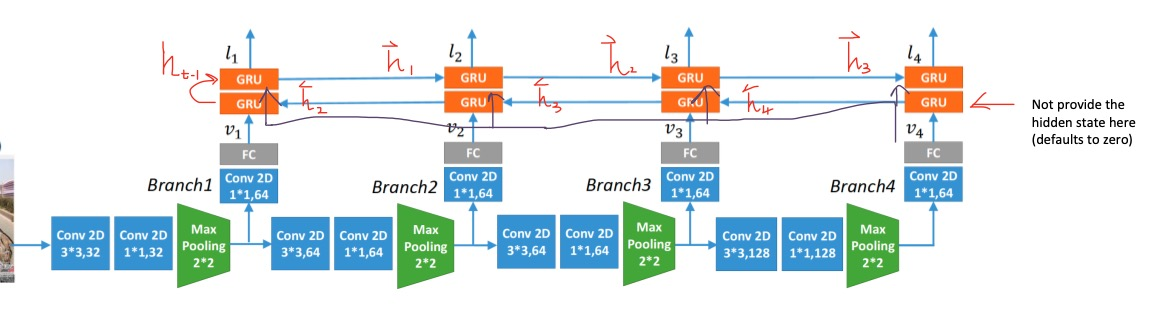

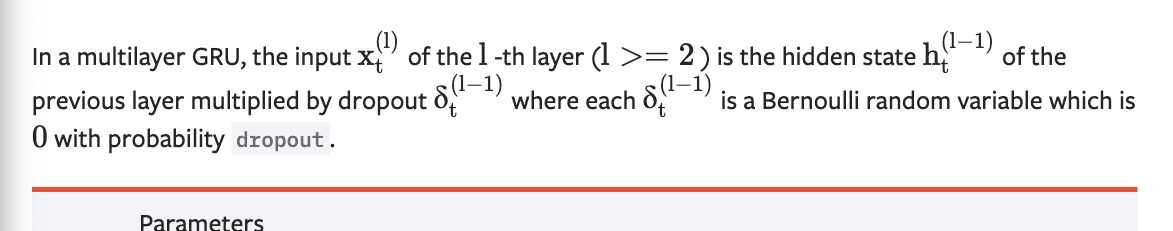

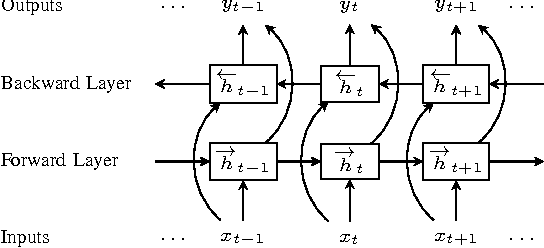

In [6]:
class PixelwithGRU_v2(PixelnoGRU):
    def __init__(self, image_height, image_width):
        super(PixelwithGRU_v2, self).__init__(image_height, image_width)
        # if input size = (batch_size(N),  channels = 3,  image height = 128, image width = 128)

        # The Bi-GRU with 2 layers
        self.gru_simple = nn.GRU(input_size=64, hidden_size=32, num_layers=2, bidirectional=True)

        self.relu = nn.ReLU()
        self.flatten = nn.Flatten(1, -1)

        self.classifier_test = nn.Sequential(nn.Linear(128, 2),
                                            nn.Dropout(0.5))
                                            # nn.LogSoftmax(dim=1)) # AG: no need for softmax if we use cross entropy loss function, which will also offer prob.
                                                            # Now the loss in the training part converges!!

    def forward(self, x, h_init):
        v1, v2, v3, v4, v_cat, p = super().forward(x)
        
        v1 = v1.unsqueeze(0) # add an extra dimension to feed into the gru model (N, 64) --> (1, N, 64)
        v2 = v2.unsqueeze(0)
        v3 = v3.unsqueeze(0)
        v4 = v4.unsqueeze(0)

        v_cat_seq_len = torch.cat((v1, v2, v3, v4), dim=0) # (1, N, 64) --> (4, N, 64)
        # print(v_cat_seq_len.shape)
        output, h = self.gru_simple(v_cat_seq_len)


        # print(h.shape) # (4, N, 32)
        h = h.permute(1,0,2) # (4, N, 32) --> (N, 4, 32)
        h = self.relu(self.flatten(h))
        # print(h.shape) # (N, 128)
        p = self.classifier_test(h)


        # print(output.shape) # (4, N, 32*num_direction)
        # output = output.permute(1,0,2) # (4, N, 32*num_direction) --> (N, 4, 32*num_direction)
        # output = self.relu(self.flatten(output))
        # print(output.shape) # (N, 128)
        # output = self.relu(output)
        # p = self.classifier_test(output)

        return p


    def init_hidden(self, batch_size):

        weight = next(self.parameters()).data
        hidden = weight.new(4, batch_size, 32).zero_().to(device)
        return hidden


# Load training set

---------
E.g., images.shape = (4, 3, 128, 128)

4 - Batch Size(no. of images loaded),

3 - channels in input,

128, 128 - shape of 1 individual image

---------


torch.Size([32, 3, 224, 224])
32
rumor_images


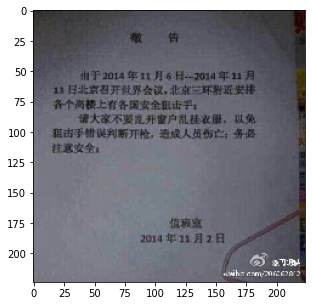

In [7]:
batch_size = 32

# use drop_last drop out the residual data that can't be divided by batch size.
trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle = True, drop_last=True) 
testloader = torch.utils.data.DataLoader(testset, batch_size = batch_size, shuffle = True, drop_last=True) 

data_iter = iter(trainloader)
images,labels = data_iter.__next__() 
print(images.shape)

print(len(labels)) # binary, len = batch size
print(classes[labels[0]])

# view original image
np_image = images[0].numpy() #converting tensor --> numpy
np_image = np.transpose(np_image, (1,2,0))
image_show(np_image)

# Pytorch Tutorial: Training on GRU. the previous class is redefined

- https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [28]:
class PixelwithGRU(PixelnoGRU):
    def __init__(self, image_height, image_width):
        super(PixelwithGRU, self).__init__(image_height, image_width)
        # if input size = (batch_size(N),  channels = 3,  image height = 128, image width = 128)

        # The 4 GRUs in layer 1
        self.gru1_1 = nn.GRU(input_size=64, hidden_size=32, num_layers=1, bidirectional=False)
        self.gru2_1 = nn.GRU(input_size=64, hidden_size=32, num_layers=1, bidirectional=False)
        self.gru3_1 = nn.GRU(input_size=64, hidden_size=32, num_layers=1, bidirectional=False)
        self.gru4_1 = nn.GRU(input_size=64, hidden_size=32, num_layers=1, bidirectional=False)

        # The 4 GRUs in layer 2
        self.gru1_2 = nn.GRU(input_size=64, hidden_size=32, num_layers=1, bidirectional=False)
        self.gru2_2 = nn.GRU(input_size=64, hidden_size=32, num_layers=1, bidirectional=False)
        self.gru3_2 = nn.GRU(input_size=64, hidden_size=32, num_layers=1, bidirectional=False)
        self.gru4_2 = nn.GRU(input_size=64, hidden_size=32, num_layers=1, bidirectional=False)

        
        self.gru_simple = nn.GRU(input_size=64, hidden_size=32, num_layers=2, bidirectional=True)


        self.relu = nn.ReLU()

        self.classifier_test = nn.Sequential(nn.Linear(256, 2))
                                            # nn.Dropout(0.5))
                                            # nn.LogSoftmax(dim=1)) # AG: no need for softmax if we use cross entropy loss function, which will also offer prob.
                                                            # Now the loss in the training part converges!!

    def forward(self, x, h_init):
        v1, v2, v3, v4, v_cat, p = super().forward(x)
        
        v1 = v1.unsqueeze(0) # add an extra dimension to feed into the gru model (4, 64) --> (1, 4, 64)
        v2 = v2.unsqueeze(0)
        v3 = v3.unsqueeze(0)
        v4 = v4.unsqueeze(0)

        # backward GRU (1st layer) which reads from v4 to v1 
        out4_layer1, h4_backward = self.gru4_1(v4)
        out3_layer1, h3_backward = self.gru3_1(v3, h4_backward)
        out2_layer1, h2_backward = self.gru2_1(v2, h3_backward)
        out1_layer1, h1_backward = self.gru1_1(v1, h2_backward)

        # print('h4_backward=',h4_backward)
        # print('h3_backward=',h3_backward)

        # print(out4_layer1.shape)   # --> (1, N, 32)
        # print(h1_backward.shape)   # --> (1, N, 32)


        # # forward GRU (2nd layer) which reads from v1 to v4 
        # out1_layer2, h1_forward = self.gru1_2(h1_backward)
        # out2_layer2, h2_forward = self.gru2_2(h2_backward, h1_backward)
        # out3_layer2, h3_forward = self.gru3_2(h3_backward, h2_backward)
        # out4_layer2, h4_forward = self.gru4_2(h4_backward, h3_backward)

        out1_layer2, h1_forward = self.gru1_2(v1)
        out2_layer2, h2_forward = self.gru2_2(v2, h1_forward)
        out3_layer2, h3_forward = self.gru3_2(v3, h2_forward)
        out4_layer2, h4_forward = self.gru4_2(v4, h3_forward)

        # print('h1_forward=',h1_forward)
        # print('h2_forward=',h2_forward)

        # print(out1_layer2.shape)  # --> (1, N, 32)
        # print(h1_forward.shape)   # --> (1, N, 32)

        # concatenating the forward hidden state and the backward hidden state along the feature dimension --> (1, N, 64)
        L1 = torch.squeeze(torch.cat((out1_layer1, out1_layer2), dim=2)) # --> (N, 64)
        L2 = torch.squeeze(torch.cat((out2_layer1, out2_layer2), dim=2))
        L3 = torch.squeeze(torch.cat((out3_layer1, out3_layer2), dim=2))
        L4 = torch.squeeze(torch.cat((out4_layer1, out4_layer2), dim=2))

 

        L_cat = torch.cat((L1, L2, L3, L4), dim=1)
        # print("\n L1 size:", L1.shape)
        # print("\n L2 size:", L2.shape)
        # print("\n L3 size:", L3.shape)
        # print("\n L4 size:", L4.shape)
        # print("\n L_cat size:", L_cat.shape)
        
        p = self.classifier_test(L_cat)
        
        return L1, L2, L3, L4, L_cat, p


    def init_hidden(self, batch_size):

        weight = next(self.parameters()).data
        hidden = weight.new(1, batch_size, 32).zero_().to(device)
        return hidden


In [29]:
#================ Which model to use? ====================
modelname = ['Pixel w/o GRU', 'Pixel with GRU', 'Pixel with GRU v2']
'''
while True:
  try:
    m = int(input("\n Which model? 0 = Pixel w/o GRU,  1 = Pixel with GRU\n "))
    if m in range(0, len(modelname)):
      print("\n!!! You have selected the", modelname[m], "model !!!")
      break
    else:  
      raise ValueError
      
  except ValueError:
    print("\nOops!  That was no valid number. Try again...")
'''
m = 1
if m == 0:
  net = PixelnoGRU(image_height, image_width)
elif m == 1:
  net = PixelwithGRU(image_height, image_width)
elif m == 2:
  net = PixelwithGRU_v2(image_height, image_width)

#========================================================
# Training on GPU
# Assuming that we are on a CUDA machine, this should print a CUDA device:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
# print(device)
net.to(device)

criterion = nn.CrossEntropyLoss() # This criterion combines LogSoftmax and NLLLoss in one single class.

learning_rate = 0.001
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)

print('\n===== Start Training ... =====')

epoch = 5

for i in range(epoch):
  count = 0
  total = 0 #torch.zeros(1, device=device)
  correct = 0

  if m == 1 or m == 2: # if use GRU model
    h_init = net.init_hidden(batch_size)

  for data in trainloader:  #Each time there is a batch size of 4 for each training step
                            #to update the model parameters
                            
    # train , labels = data
    train, labels = data[0].to(device), data[1].to(device) # assume on CUDA device
    # print("\n train.shape:", train.shape)
    # print("\n labels.shape:", labels.shape)

    # clear parameter gradients (clear weights)
    optimizer.zero_grad()  

    # forward propagation
    if m == 1:
      _, _, _, _, _, outputs = net(train, h_init) # outputs.shape = (N, 2)

    elif m == 2:
      outputs = net(train, h_init) # outputs.shape = (N, 2)

    else:
      _, _, _, _, _, outputs = net(train) # outputs.shape = (N, 2)

    # print(outputs)
    # Calculate cross entropy loss
    loss = criterion(outputs, labels) # Input: (N, C), C=number of classes, Target: (N)

    # Calculating gradients
    loss.backward(retain_graph=True) # retain_graph=True to keep temporary information necessary for backward propagation

    # Update weights
    optimizer.step()

    _, predicted = torch.max(outputs.data, dim=1) # returns indices of the largest prob. --> the predicted label
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    # print('total = ', total)
    # print('correct = ', correct)

    count += 1
    if count % 10 == 0:
        accuracy = 100 * correct / total
        # print statistics
        print(modelname[m], ': Epoch: %d/%d  Iteration: %5d  Loss: %5f  Train Accuracy: %5f' %(i+1, epoch, count, loss.data, accuracy))

print('\n===== Finished Training =====')
# torch.save(the_model, PATH)


===== Start Training ... =====
Pixel with GRU : Epoch: 1/5  Iteration:    10  Loss: 0.680083  Train Accuracy: 50.625000
Pixel with GRU : Epoch: 1/5  Iteration:    20  Loss: 0.684787  Train Accuracy: 54.375000
Pixel with GRU : Epoch: 1/5  Iteration:    30  Loss: 0.685745  Train Accuracy: 56.041667
Pixel with GRU : Epoch: 1/5  Iteration:    40  Loss: 0.678438  Train Accuracy: 55.468750
Pixel with GRU : Epoch: 1/5  Iteration:    50  Loss: 0.662527  Train Accuracy: 55.437500
Pixel with GRU : Epoch: 1/5  Iteration:    60  Loss: 0.721805  Train Accuracy: 55.052083
Pixel with GRU : Epoch: 1/5  Iteration:    70  Loss: 0.709906  Train Accuracy: 55.580357
Pixel with GRU : Epoch: 1/5  Iteration:    80  Loss: 0.651397  Train Accuracy: 56.250000
Pixel with GRU : Epoch: 1/5  Iteration:    90  Loss: 0.672706  Train Accuracy: 56.284722
Pixel with GRU : Epoch: 1/5  Iteration:   100  Loss: 0.712793  Train Accuracy: 56.593750
Pixel with GRU : Epoch: 1/5  Iteration:   110  Loss: 0.662690  Train Accuracy:

KeyboardInterrupt: ignored

In [30]:
y_pred = predicted.cpu()
y_true =  labels.cpu()

#Code:
from sklearn.metrics import accuracy_score # normal accuracy
from sklearn.metrics import balanced_accuracy_score # used in case of imbalanced data sets, average of recall, from 0 to 1
from sklearn.metrics import confusion_matrix # division of performance on the multilabels
from sklearn.metrics import cohen_kappa_score # compares model against random prediction, from -1 to 1
from sklearn.metrics import classification_report # for multilabel classification, gives precision, recall, f score, support, more
target_names = ['class 0', 'class 1']
def print_metrics(y_true, y_pred):
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Balanced Accuracy:" , balanced_accuracy_score(y_true, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("Cohen Kappa Score:", cohen_kappa_score(y_true, y_pred))
    print("Classification Report:\n", classification_report(y_true, y_pred, target_names=target_names))
print_metrics(y_true, y_pred)

Accuracy: 0.5625
Balanced Accuracy: 0.5
Confusion Matrix:
 [[ 0 14]
 [ 0 18]]
Cohen Kappa Score: 0.0
Classification Report:
               precision    recall  f1-score   support

     class 0       0.00      0.00      0.00        14
     class 1       0.56      1.00      0.72        18

    accuracy                           0.56        32
   macro avg       0.28      0.50      0.36        32
weighted avg       0.32      0.56      0.40        32



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Trained model's performance on test set?
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

correct = 0
total = 0
count = 0
with torch.no_grad():
    for data in testloader:
        print('count = ', count)
        test, labels = data[0].to(device), data[1].to(device) # assume on CUDA device
        _, _, _, _, _, outputs = net(test)
        _, predicted = torch.max(outputs.data, dim=1) # returns indices of the largest prob. --> the predicted label
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        c = (predicted == labels).squeeze()
        # print(c)
        # print(c[0].item())
        # print(int(c[0].item()))
        # print(labels)

        for i in range(len(c)):
            label = labels[i].item()
            # print(label)
            # print(label.item())
            # print(c[i].item())
            class_correct[label] += int(c[i].item()) 
            # print(class_correct)
            class_total[label] += 1
        count += 1

accuracy = 100 * correct / total
print(modelname[m], ':  Test Accuracy: %5f ' %(accuracy))

# print(modelname[m], ':  Test Accuracy: %5f  Accuracy of %s : %5f  Accuracy of %s : %5f' 
#       %(accuracy, classes[0], 100 * class_correct[0] / class_total[0], classes[1], 100 * class_correct[1] / class_total[1]))